
## Multi-dimensional Scaling

#### Jonathan Markel
#### Department of Aerospace Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Lei Liu, Graduate Student, The University of Texas at Austin
##### [LinkedIn]()


### Executive Summary

Coastal environments are front lines of climate change and many coastlines are experiencing erosion due to sea level rise, increased storm frequency, and more. We aim to better understand drivers and predicted erosion for California. It is valuable to know which beaches are eroding fastest, and to better understand similarities in erosional drivers.

We use Multi-dimensional Scaling (MDS) to visualize data of coastline in the Americas, comparing its linear trended change in shoreline position to a number of other factors, including orientation angle of the beach, the slope of the beach, and the shoreline location.

We show that the relationship between factors like beach slope, orientation, and erosional trend are non-linear and try to project them to a 2D space to analyze overall similarity. We find that the applications of MDS are limited by highly non-linear systems like shoreline change.

We recommend the use of Euclidean distances for visualizing shoreline transects from this dataset. We note significant variations across continents regarding drivers of erosion like beach slope, beach orientation, and more. We recommend the use of normalization parameters and careful selection of informative continous feautures for best results. MDS can be used to compare coastal zones with similar erosion rates and drivers by projecting points into a 2D space which optimally preserves pair-wise distances between data points.


### Import Packages

Lets import Python packages used in this workflow.

In [14]:
import numpy as np          # for common array operations
import geopandas as gpd     # for reading, exploring, and writing geospatial data
import seaborn as sns       # for data visualization
from sklearn.preprocessing import StandardScaler  # for standardizing numeric data
import matplotlib.pyplot as plt # for visualization

from sklearn.manifold import MDS   # multidimensional scaling
from sklearn.metrics.pairwise import euclidean_distances # for comparing distance metrics...
from sklearn.metrics import pairwise_distances  

import warnings # suppress warnings
warnings.filterwarnings('ignore')


## Load Data
The following workflow applies the file 'transects_edit.geojson', a dataset of shoreline change across the Pacific calculated from satellite imagery. The dataset is a product of the Nature Geoscience paper [Time-series of shoreline change along the Pacific Rim](https://doi.org/10.1038/s41561-022-01117-8) and is available for download [here](https://zenodo.org/records/7758183). We have stored it (downloaded November 2023) in a Github repository for easier reading from any notebook and to account for dataset changes.

In [15]:
# may take several seconds, full file is 55MB for several continents of data, we'll subset shortly
dataset_url = 'https://raw.githubusercontent.com/jonm3D/PGE383_Data/main/transects_edit.geojson'
df = gpd.read_file(dataset_url)

df.head()

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,id,geometry
0,aus0001,104.347648,0.000000,0.000000,0.085,0.0545,0.2000,-1.892087,654.0,342.0,aus0001-0000,"LINESTRING (153.26555 -24.70070, 153.26938 -24..."
1,aus0001,93.495734,98.408334,0.002935,0.050,0.0387,0.0640,-1.205575,654.0,473.0,aus0001-0001,"LINESTRING (153.26525 -24.70190, 153.26920 -24..."
2,aus0001,82.069341,198.408334,0.005918,0.050,0.0428,0.0647,-0.698779,654.0,491.0,aus0001-0002,"LINESTRING (153.26539 -24.70316, 153.26931 -24..."
3,aus0001,81.192757,298.402523,0.008900,0.055,0.0480,0.0659,-0.303470,654.0,502.0,aus0001-0003,"LINESTRING (153.26555 -24.70408, 153.26945 -24..."
4,aus0001,81.065473,398.402523,0.011882,0.075,0.0614,0.0922,-0.105642,654.0,508.0,aus0001-0004,"LINESTRING (153.26570 -24.70497, 153.26961 -24..."


If desired, use an interactive plot to explore the data on a map. We sample the data to improve visualization performance. Cell is best viewed using Jupyter Notebooks or Jupyter Lab.

In [18]:
# df.sample(1000).explore()

### 1. Data Cleaning

We need to clean up our dataset for the purposes of this workflow. This is a large dataset (100k+ rows), and we can afford some data loss. Let's remove any rows which have a NaN value as a result of their original processing. Let's also convert the transect (vector) geometries from the original data to points which capture the overall spatial distribution of data. Lastly, we'll sample the data to a smaller number of points for purposes of this visualization and reproducability.

In [19]:
data = df.copy()

# remote any rows with NaN
data = data.dropna(axis=0)

# add columns for X and Y of the shoreline data 
data.loc[:, 'x_c'] = data.geometry.apply(lambda x: x.centroid.x)
data.loc[:, 'y_c'] = data.geometry.apply(lambda x: x.centroid.y)

# create a column for region using the 'siteID'
data.loc[:, 'region'] = df.site_id.apply(lambda x: x[:3])

# use only data from the US
# data = data[data.region == 'usa']

# # read in geojson to use for trimming file
data_aoi = gpd.read_file('south_america.geojson')
data = gpd.clip(data, data_aoi)

# reset the index for region filtered data
data = data.reset_index(drop=True)

# add a column for the region
data.loc[:, 'region'] = data.site_id.apply(lambda x: x[:3])

# remove unneeded columns
data = data.loc[:, ['orientation', 'x_c', 'y_c', 'beach_slope', 'trend', 'along_dist_norm', 'n_points_nonan', 'region']]

# rename columns for formatting
data.columns = ['Orientation', 'Longitude', 'Latitude', 'Slope', 'Trend', 'Alongshore', 'N', 'Region']

# sample to reduce size for workflow
data = data.sample(250, random_state=42)

# add normalized / scaled columns
data.loc[:, 'nLongitude'] = StandardScaler().fit_transform(data.Longitude.values.reshape(-1, 1))
data.loc[:, 'nLatitude'] = StandardScaler().fit_transform(data.Latitude.values.reshape(-1, 1)) 
data.loc[:, 'nSlope'] = StandardScaler().fit_transform(data.Slope.values.reshape(-1, 1))
data.loc[:, 'nTrend'] = StandardScaler().fit_transform(data.Trend.values.reshape(-1, 1))
data.loc[:, 'nOrientation'] = StandardScaler().fit_transform(data.Orientation.values.reshape(-1, 1))
data.loc[:, 'nAlongshore'] = StandardScaler().fit_transform(data.Alongshore.values.reshape(-1, 1))
data.loc[:, 'nN'] = StandardScaler().fit_transform(data.N.values.reshape(-1, 1))

# add geomerty column
data.loc[:, 'geometry'] = df.geometry

# make gdf
data = gpd.GeoDataFrame(data)

data.head()

,Orientation,Longitude,Latitude,Slope,Trend,Alongshore,N,Region,nLongitude,nLatitude,nSlope,nTrend,nOrientation,nAlongshore,nN,geometry
43818,251.016258,-115.199056,29.452987,0.070,0.209143,0.333318,640.0,mex,-1.163292,0.994048,-0.003788,-0.127733,0.260386,-0.626537,0.706156,"LINESTRING (-110.27870 23.49682, -110.28231 23..."
31469,219.767010,-105.294755,21.530639,0.050,4.767238,0.955236,686.0,mex,-0.622454,0.678337,-0.635113,2.511901,-0.462555,1.527433,0.918787,"LINESTRING (-94.45797 16.17891, -94.45880 16.1..."
51271,308.816093,-124.358374,40.289507,0.075,0.453072,0.214651,485.0,usa,-1.663450,1.425892,0.154043,0.013528,1.597565,-1.037534,-0.010317,"LINESTRING (-114.19500 28.00766, -114.19826 28..."
25182,208.198482,-99.715253,16.720018,0.055,-0.016474,0.411420,501.0,mex,-0.317777,0.486630,-0.477281,-0.258390,-0.730189,-0.356036,0.063641,"LINESTRING (-159.76569 22.07738, -159.76863 22..."
48319,232.547902,-119.997406,34.455279,0.110,0.141295,0.608480,713.0,usa,-1.425313,1.193393,1.258861,-0.167024,-0.166873,0.326467,1.043592,"LINESTRING (-112.10883 25.39101, -112.11278 25..."


### 2. Data Inspection
We need to inspect our data to be confident in it's validity. Let's use the Seaborn pairplot to understand the (non)linearity of relationships within our dataset. We can also visualize by latitude to get a basic sense of spatial dependence within the data.

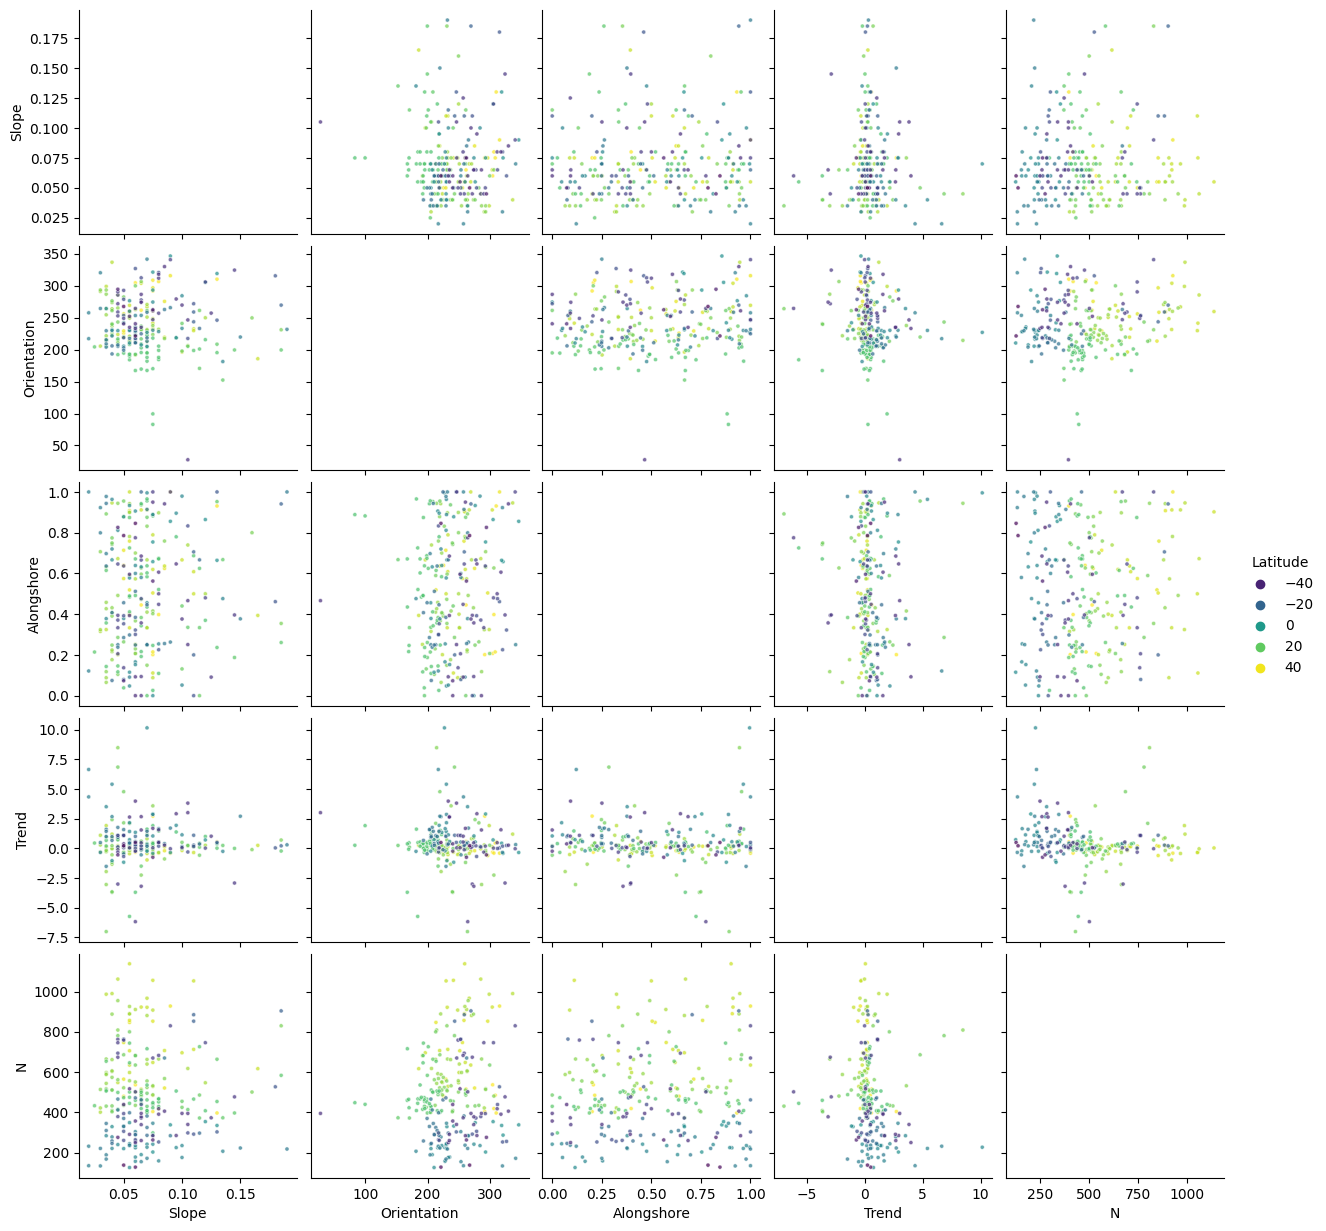

In [22]:
# Your existing code with a check for scale
data_plot = data.loc[:, ['Slope', 'Orientation', 'Alongshore', 'Trend', 'Latitude', 'N']].sort_values('Latitude', ascending=False)

sns.pairplot(data_plot, markers='.', palette='viridis', hue='Latitude', plot_kws={'alpha':0.7})

### 3. Multi-dimensional Scaling (MDS)
Let's perform MDS to reduce the dimensionality of our data and better understand similarity within our dataset. We'll start by using only normalized variables (MDS is based on distance metrics and susceptible to variation in distance calculations). We perform the MDS optimization for both euclidean and manhattan distances in an effort to understand how beaches are eroding.

In [23]:
# Your existing code for normalized data and setting n_components
data_norm = data.loc[:, ['nSlope', 'nOrientation', 'nTrend', 'nAlongshore', 'nN', 'nLatitude', 'nLongitude']]
n_components = 2

# MDS with Euclidean distance
embedding_euclidean = MDS(n_components=n_components, metric=True, verbose=1, random_state=100)
MDS_transformed_euclidean = embedding_euclidean.fit_transform(data_norm)

# Create a DataFrame for the Euclidean MDS results
df_mds_euclidean = data_norm.copy()
df_mds_euclidean['MDS1_euclidean'] = MDS_transformed_euclidean[:, 0]
df_mds_euclidean['MDS2_euclidean'] = MDS_transformed_euclidean[:, 1]

# MDS with Manhattan distance
embedding_manhattan = MDS(n_components=n_components, metric=True, dissimilarity='precomputed', verbose=1, random_state=100)
manhattan_distances = pairwise_distances(data_norm, metric='manhattan')
MDS_transformed_manhattan = embedding_manhattan.fit_transform(manhattan_distances)

# Create a DataFrame for the Manhattan MDS results
df_mds_manhattan = data_norm.copy()
df_mds_manhattan['MDS1_manhattan'] = MDS_transformed_manhattan[:, 0]
df_mds_manhattan['MDS2_manhattan'] = MDS_transformed_manhattan[:, 1]

print('MDS with Euclidean distance')
df_mds_euclidean.head()

print('MDS with Manhattan distance')
df_mds_manhattan.head()


breaking at iteration 276 with stress 25337.384520029562
breaking at iteration 282 with stress 24729.91858259288
breaking at iteration 240 with stress 102175.21029698258
breaking at iteration 286 with stress 104281.57488603226
breaking at iteration 242 with stress 102077.09211439772
MDS with Euclidean distance
MDS with Manhattan distance


,nSlope,nOrientation,nTrend,nAlongshore,nN,nLatitude,nLongitude,MDS1_manhattan,MDS2_manhattan
43818,-0.003788,0.260386,-0.127733,-0.626537,0.706156,0.994048,-1.163292,0.276528,4.251091
31469,-0.635113,-0.462555,2.511901,1.527433,0.918787,0.678337,-0.622454,-6.587552,2.923323
51271,0.154043,1.597565,0.013528,-1.037534,-0.010317,1.425892,-1.663450,2.854619,5.800152
25182,-0.477281,-0.730189,-0.258390,-0.356036,0.063641,0.486630,-0.317777,0.257766,1.535383
48319,1.258861,-0.166873,-0.167024,0.326467,1.043592,1.193393,-1.425313,-2.271585,5.487786


### Results
Let's visualize the results of the MDS procedure on our dataset. We are interested in understanding rates of erosion, so we color points by linear trend (cross-shore erosion), and plot the data on the Euclidean/Manhattan-distance projeected coordinates.

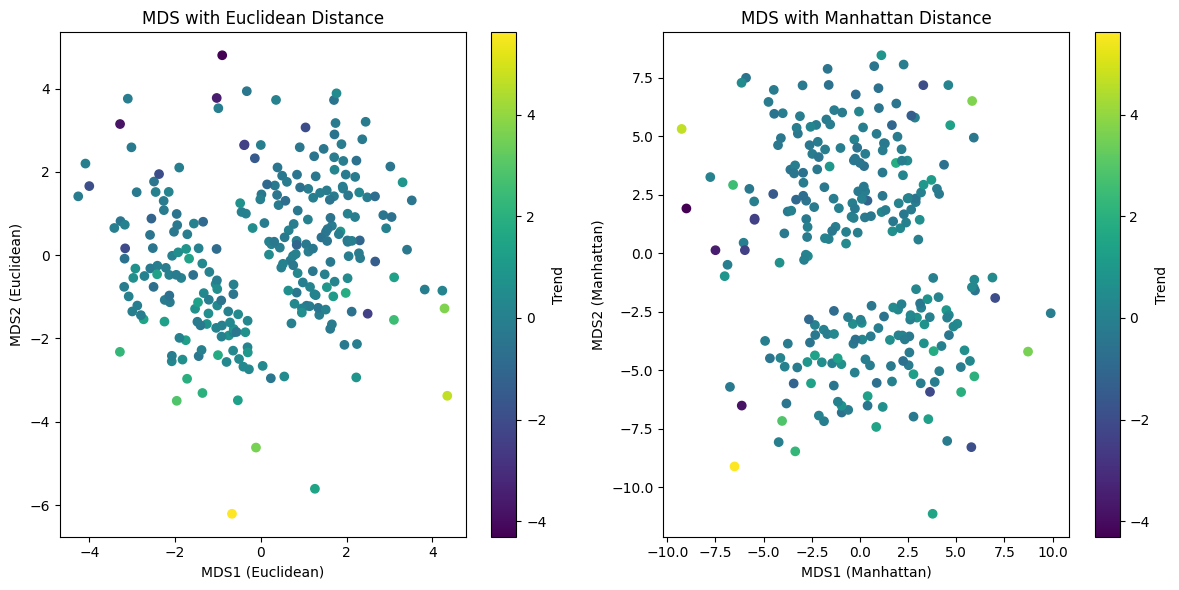

In [8]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Euclidean MDS
sc1 = axes[0].scatter(df_mds_euclidean['MDS1_euclidean'], df_mds_euclidean['MDS2_euclidean'], 
                      c=df_mds_euclidean['nTrend'], cmap='viridis')
axes[0].set_title('MDS with Euclidean Distance')
axes[0].set_xlabel('MDS1 (Euclidean)')
axes[0].set_ylabel('MDS2 (Euclidean)')
plt.colorbar(sc1, ax=axes[0], label='Trend')

# Plot for Manhattan MDS
sc2 = axes[1].scatter(df_mds_manhattan['MDS1_manhattan'], df_mds_manhattan['MDS2_manhattan'], 
                      c=df_mds_manhattan['nTrend'], cmap='viridis')
axes[1].set_title('MDS with Manhattan Distance')
axes[1].set_xlabel('MDS1 (Manhattan)')
axes[1].set_ylabel('MDS2 (Manhattan)')
plt.colorbar(sc2, ax=axes[1], label='Trend')

# Adjust layout
plt.tight_layout()
plt.show()


It's useful to retain original information for each distance metric, so we'll store them here.

In [24]:
df_mds_euclidean = data_norm.copy()
df_mds_euclidean['MDS1_euclidean'] = MDS_transformed_euclidean[:, 0]
df_mds_euclidean['MDS2_euclidean'] = MDS_transformed_euclidean[:, 1]

# Add original columns for plotting
df_mds_euclidean['Slope'] = data['Slope'].values
df_mds_euclidean['Orientation'] = data['Orientation'].values
df_mds_euclidean['Trend'] = data['Trend'].values
df_mds_euclidean['Latitude'] = data['Latitude'].values
df_mds_euclidean['Longitude'] = data['Longitude'].values
df_mds_euclidean['Alongshore'] = data['Alongshore'].values
df_mds_euclidean['N'] = data['N'].values
df_mds_euclidean['Region'] = data['Region'].values

df_mds_manhattan = data_norm.copy()
df_mds_manhattan['MDS1_manhattan'] = MDS_transformed_manhattan[:, 0]
df_mds_manhattan['MDS2_manhattan'] = MDS_transformed_manhattan[:, 1]

# Add original columns for plotting
df_mds_manhattan['Slope'] = data['Slope'].values
df_mds_manhattan['Orientation'] = data['Orientation'].values
df_mds_manhattan['Trend'] = data['Trend'].values
df_mds_manhattan['Latitude'] = data['Latitude'].values
df_mds_manhattan['Longitude'] = data['Longitude'].values
df_mds_manhattan['Alongshore'] = data['Alongshore'].values
df_mds_manhattan['N'] = data['N'].values
df_mds_manhattan['Region'] = data['Region'].values



Let's visualize the results of MDS and color by the trend (m / yr change in shoreline position) derived from satellite imagery. This will better help us identify outliers and trends in the coastal erosion data.

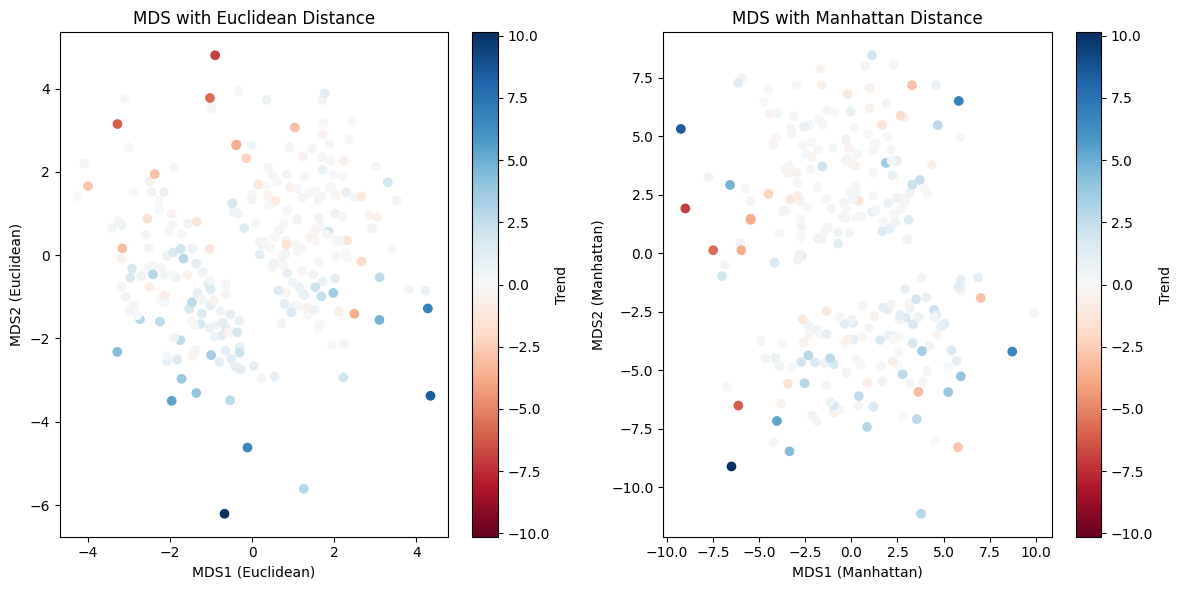

In [10]:
# Find the maximum absolute value in the 'Trend' data for scaling
max_trend_value = max(df_mds_euclidean['Trend'].abs().max(), df_mds_manhattan['Trend'].abs().max())

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Euclidean MDS
sc1 = axes[0].scatter(df_mds_euclidean['MDS1_euclidean'], df_mds_euclidean['MDS2_euclidean'], 
                      c=df_mds_euclidean['Trend'], cmap='RdBu', vmin=-max_trend_value, vmax=max_trend_value)
axes[0].set_title('MDS with Euclidean Distance')
axes[0].set_xlabel('MDS1 (Euclidean)')
axes[0].set_ylabel('MDS2 (Euclidean)')
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('Trend')

# Plot for Manhattan MDS
sc2 = axes[1].scatter(df_mds_manhattan['MDS1_manhattan'], df_mds_manhattan['MDS2_manhattan'], 
                      c=df_mds_manhattan['Trend'], cmap='RdBu', vmin=-max_trend_value, vmax=max_trend_value)
axes[1].set_title('MDS with Manhattan Distance')
axes[1].set_xlabel('MDS1 (Manhattan)')
axes[1].set_ylabel('MDS2 (Manhattan)')
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Trend')

# Adjust layout
plt.tight_layout()
plt.show()


Let's also visualize the results of our MDS transformation by plotting the original pairwise distances between points to their reprojected pairwise distances. The better the original pairwise distances are represented by the MDS projected data, the more linear their relationship should be.

We can see that for this dataset the reprojected pairwise euclidean distances are significantly more linear than the Manhattan distances, indicating MDS applications should use prioritize Euclidean metrics accordingly. The closer the distance ratio is to 1, the better the reprojection.


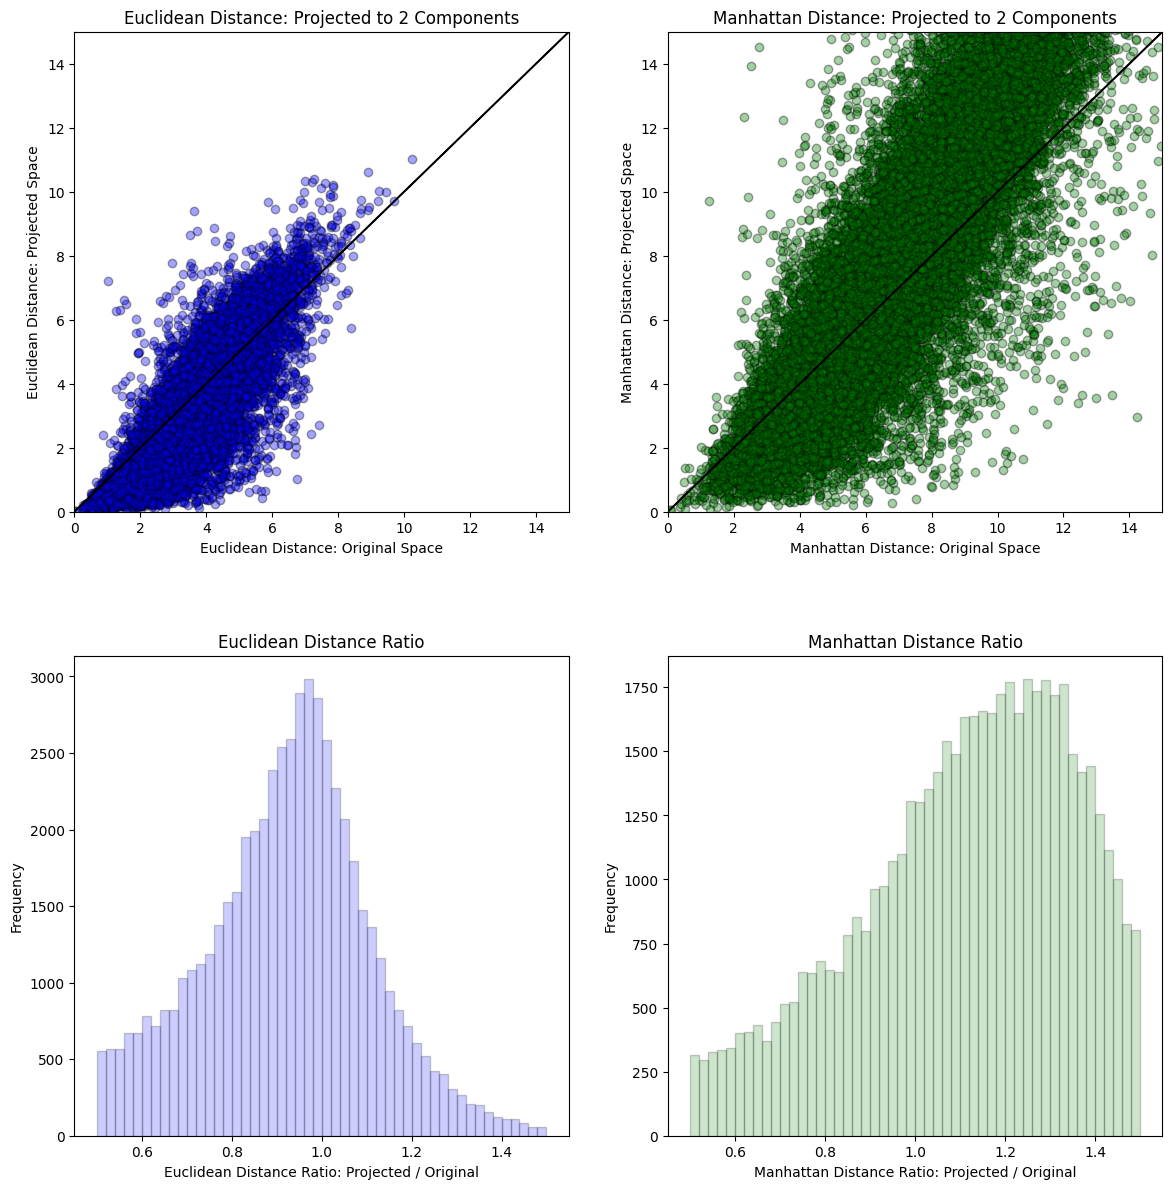

In [26]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
import numpy as np
import matplotlib.pyplot as plt

# Euclidean distances
dists_euclidean = euclidean_distances(data_norm, squared=False).ravel()
nonzero_euclidean = dists_euclidean != 0
dists_euclidean = dists_euclidean[nonzero_euclidean]
projected_dists_euclidean = euclidean_distances(MDS_transformed_euclidean, squared=False).ravel()[nonzero_euclidean]
rates_euclidean = projected_dists_euclidean / dists_euclidean

# Manhattan distances
dists_manhattan = manhattan_distances(data_norm).ravel()
nonzero_manhattan = dists_manhattan != 0
dists_manhattan = dists_manhattan[nonzero_manhattan]
projected_dists_manhattan = manhattan_distances(MDS_transformed_manhattan).ravel()[nonzero_manhattan]
rates_manhattan = projected_dists_manhattan / dists_manhattan

# Code via Michael Pyrcz
# https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Multidimensional_Scaling.ipynb

# Euclidean distances plot
plt.subplot(221)
plt.scatter(dists_euclidean, projected_dists_euclidean, c='blue', alpha=0.2, edgecolor='black')
plt.arrow(0, 0, 200, 200, width=0.02, color='black', head_length=0.0, head_width=0.0)
plt.xlim(0, 15); plt.ylim(0, 15)
plt.xlabel("Euclidean Distance: Original Space")
plt.ylabel("Euclidean Distance: Projected Space")
plt.title("Euclidean Distance: Projected to %d Components" % n_components)

# Manhattan distances plot
plt.subplot(222)
plt.scatter(dists_manhattan, projected_dists_manhattan, c='green', alpha=0.2, edgecolor='black')
plt.arrow(0, 0, 200, 200, width=0.02, color='black', head_length=0.0, head_width=0.0)
plt.xlim(0, 15); plt.ylim(0, 15)
plt.xlabel("Manhattan Distance: Original Space")
plt.ylabel("Manhattan Distance: Projected Space")
plt.title("Manhattan Distance: Projected to %d Components" % n_components)

# Histograms for Euclidean
plt.subplot(223)
plt.hist(rates_euclidean, bins=50, range=(0.5, 1.5), color='blue', alpha=0.2, edgecolor='k')
plt.xlabel("Euclidean Distance Ratio: Projected / Original")
plt.ylabel("Frequency")
plt.title("Euclidean Distance Ratio")

# Histograms for Manhattan
plt.subplot(224)
plt.hist(rates_manhattan, bins=50, range=(0.5, 1.5), color='green', alpha=0.2, edgecolor='k')
plt.xlabel("Manhattan Distance Ratio: Projected / Original")
plt.ylabel("Frequency")
plt.title("Manhattan Distance Ratio")

# Adjust layout
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.7, top=2.3, wspace=0.2, hspace=0.3)
plt.show()
